In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/200k-youtube-channel-analytics/all_youtube_analytics.csv


# First, some EDA

In [13]:
train_data = pd.read_csv("/kaggle/input/200k-youtube-channel-analytics/all_youtube_analytics.csv")
train_data.head()

,video_id,day,views,redViews,comments,likes,dislikes,videosAddedToPlaylists,videosRemovedFromPlaylists,shares,...,annotationClicks,annotationCloses,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks,subscribersGained,subscribersLost
0,YuQaT52VEwo,2019-09-06,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,YuQaT52VEwo,2019-09-07,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SfTEVOQP-Hk,2019-09-07,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,YuQaT52VEwo,2019-09-08,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SfTEVOQP-Hk,2019-09-08,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234889 entries, 0 to 234888
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   video_id                        234889 non-null  object 
 1   day                             234889 non-null  object 
 2   views                           234889 non-null  float64
 3   redViews                        234889 non-null  float64
 4   comments                        234889 non-null  float64
 5   likes                           234889 non-null  float64
 6   dislikes                        234889 non-null  float64
 7   videosAddedToPlaylists          234889 non-null  float64
 8   videosRemovedFromPlaylists      234889 non-null  float64
 9   shares                          234889 non-null  float64
 10  estimatedMinutesWatched         234889 non-null  float64
 11  estimatedRedMinutesWatched      234889 non-null  float64
 12  averageViewDurat

In [44]:
# Checking to ensure uniqueness of video_id by day
train_data.duplicated(['video_id', 'day']).sum()

0

In [58]:
# Creating a dataframe of video_id row counts, to remove videos with few data points
video_id_row_count_df = train_data['video_id'].value_counts().reset_index()
video_id_row_count_df.columns = ['video_id', 'row_count']
video_id_row_count_df.head()

,video_id,row_count
0,YuQaT52VEwo,1893
1,SfTEVOQP-Hk,1892
2,bN7jBc95XDo,1890
3,V1YwVETqB2c,1888
4,WRD9aHXC89I,1882


<Figure size 1000x800 with 0 Axes>

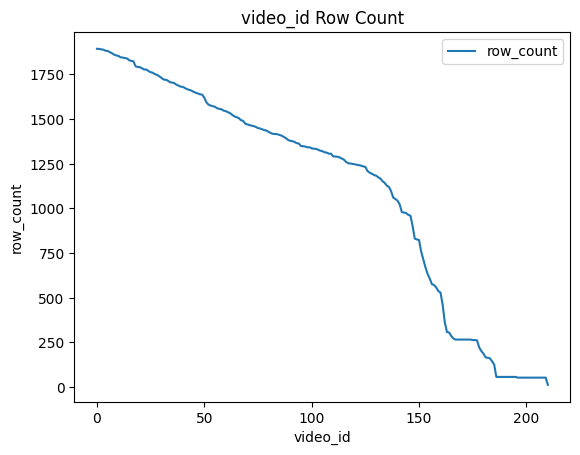

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
video_id_row_count_df.sort_index().plot(kind = 'line')
plt.title('video_id Row Count')
plt.xlabel('video_id')
plt.ylabel('row_count')
plt.show()

In [63]:
def check_continuous_day(df):
    df['day'] = pd.to_datetime(df['day'], errors = 'coerce')
    df = df.sort_values(by = ['video_id', 'day'])
    df['next_day'] = df.groupby('video_id')['day'].shift(-1)
    df['continuous_day_flag'] = (df['day'] + pd.Timedelta(days = 1)) == df['next_day']
    return df

In [67]:
video_id_day = train_data.loc[:, ['video_id', 'day']]
check_continuous_day(video_id_day)

,video_id,day,next_day,continuous_day_flag
10877,-4G1CgJqnHM,2020-08-10,2020-08-11,True
10914,-4G1CgJqnHM,2020-08-11,2020-08-12,True
10975,-4G1CgJqnHM,2020-08-12,2020-08-13,True
11021,-4G1CgJqnHM,2020-08-13,2020-08-14,True
11126,-4G1CgJqnHM,2020-08-14,2020-08-15,True
...,...,...,...,...
233968,zoOl1hw04L0,2024-11-06,2024-11-07,True
234100,zoOl1hw04L0,2024-11-07,2024-11-08,True
234413,zoOl1hw04L0,2024-11-08,2024-11-09,True
234521,zoOl1hw04L0,2024-11-09,2024-11-10,True
